In [1]:
import torch
from torch import optim, nn, utils, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
# Define encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim, channels_A, channels_B, channels_C, data_channels):
        super(Encoder, self).__init__()
        total_channels = data_channels * channels_C
        # 3 CNN layers
        self.conv_DataA = nn.Conv2d(in_channels=data_channels, out_channels=data_channels * channels_A, kernel_size=5, stride=1)
        self.conv_AB = nn.Conv2d(in_channels=data_channels * channels_A, out_channels=data_channels * channels_B, kernel_size=3, stride=1)
        self.conv_BC = nn.Conv2d(in_channels=data_channels * channels_B, out_channels=total_channels, kernel_size=3, stride = 1)
        # Feature space to latent space
        self.fc_Cmean = nn.Linear(in_features = total_channels * 20 * 20, out_features=latent_dim)
        self.fc_Clog_var = nn.Linear(in_features = total_channels * 20 * 20, out_features=latent_dim)

    def forward(self, x):
        # Apply layers
        x = F.relu(self.conv_DataA(x))
        x = F.relu(self.conv_AB(x))
        x = F.relu(self.conv_BC(x))
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_Cmean(x)
        log_var = self.fc_Clog_var(x)
        return mu, log_var

In [3]:
# Define decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, channels_C, channels_B, channels_A, data_channels):
        super(Decoder, self).__init__()
        self.total_channels = data_channels * channels_C
        # Latent space to feature space
        self.fc_LC = nn.Linear(in_features=latent_dim, out_features=self.total_channels * 20 * 20)
        # 3 CNN Transpose layers
        self.conv_tCB = nn.ConvTranspose2d(in_channels=data_channels * channels_C, out_channels=data_channels * channels_B, kernel_size=3, stride=1)
        self.conv_tBA = nn.ConvTranspose2d(in_channels=data_channels * channels_B, out_channels=data_channels * channels_A, kernel_size=3, stride=1)
        self.conv_tAData = nn.ConvTranspose2d(in_channels=data_channels * channels_A, out_channels=data_channels, kernel_size=5, stride=1)

    def forward(self, z):
        # Apply layers
        z = self.fc_LC(z)
        z = z.view(-1, self.total_channels, 20, 20)
        z = F.relu(self.conv_tCB(z))
        z = F.relu(self.conv_tBA(z))
        recon = torch.sigmoid(self.conv_tAData(z))
        return recon

In [4]:
# Define VAE
class VAE(nn.Module):
    def __init__(self, latent_dim, channels_A, channels_B, channels_C, data_channels):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim, channels_A, channels_B, channels_C, data_channels)
        self.decoder = Decoder(latent_dim, channels_C, channels_B, channels_A, data_channels)

    def reparameterize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)

    def forward(self, x, do_reparam = True):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var) if do_reparam else mu
        return self.decoder(z), mu, log_var

In [5]:
# Define Evaluator
class Evaluator(nn.Module):
    def __init__(self, data_dim, hidden_dim1, hidden_dim2, value_dim):
        super(Evaluator, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(data_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.value = nn.Linear(hidden_dim2, value_dim)

    def forward(self, x):
        # Apply non-linear transformations
        x = torch.flatten(x, start_dim = 1)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        evaluation = F.relu(self.value(h2))
        return evaluation

In [6]:
# Define sample displayer
def displayer(sampling, x_len, data_x, data_y, rgb = False):
    fig_x = min(sampling, x_len)
    fig, axes = plt.subplots(2, fig_x, figsize=(fig_x, 2))

    if rgb:
        for i in range(0, fig_x):
            pos = i % fig_x
            image = x[i].permute(1, 2, 0)
            axes[int(i/fig_x)*2][pos].imshow(image.cpu())
            axes[int(i/fig_x)*2][pos].axis('off')  # Turn off axis numbers

            image = recon_x[i].permute(1, 2, 0)
            axes[int(i/fig_x)*2+1][pos].imshow(image.detach().cpu())
            axes[int(i/fig_x)*2+1][pos].axis('off')  # Turn off axis numbers
        plt.show()
        plt.close()
    else:
        for i in range(0, fig_x):
            pos = i % fig_x
            image = x[i].view(data_x, data_y)
            axes[int(i/fig_x)*2][pos].imshow(image.cpu(), cmap='gray')
            axes[int(i/fig_x)*2][pos].axis('off')  # Turn off axis numbers

            image = recon_x[i].view(data_x, data_y)
            axes[int(i/fig_x)*2+1][pos].imshow(image.detach().cpu(), cmap='gray')
            axes[int(i/fig_x)*2+1][pos].axis('off')  # Turn off axis numbers
        plt.show()
        plt.close()

In [8]:
# Randomness control
torch.manual_seed(2022313045)

# Metadata
dataset_folder = '../Datasets'
data_is_rgb = False
data_channels = 3 if data_is_rgb else 1
data_x = 28
data_y = 28
latent_dim = 200
channels_C = 32
channels_B = 16
channels_A = 8
data_dim = data_channels * data_x * data_y
hidden_dim1 = 400
hidden_dim2 = 200
value_dim = 100

# Set computing device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

    # Datasets
mnist_train = MNIST('../../Datasets', train=True, download=True, transform=transform)
mnist_test = MNIST('../../Datasets', train=False, download=True, transform=transform)

# Neural Networks
model = VAE(latent_dim, channels_A, channels_B, channels_C, data_channels).to(device)
evaluator = Evaluator(data_dim, hidden_dim1, hidden_dim2, value_dim).to(device)

In [10]:
model = VAE(latent_dim, channels_A, channels_B, channels_C, data_channels).to(device)
evaluator = Evaluator(data_dim, hidden_dim1, hidden_dim2, value_dim).to(device)
optimizer_VAE = optim.Adam(model.parameters(), lr=0.0005)
optimizer_Eval = optim.Adam(evaluator.parameters(), lr=0.00005)
optimizer_EVAE = optim.Adam(list(model.parameters()) + list(evaluator.parameters()), lr=0.0001)

checkpoint = torch.load('mnist_model_1.pt', map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
evaluator.load_state_dict(checkpoint['evaluator_state_dict'])
optimizer_VAE.load_state_dict(checkpoint['optimizer_VAE_state_dict'])
optimizer_Eval.load_state_dict(checkpoint['optimizer_Eval_state_dict'])
optimizer_EVAE.load_state_dict(checkpoint['optimizer_EVAE_state_dict'])

model.eval()
evaluator.eval()

Evaluator(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (value): Linear(in_features=200, out_features=100, bias=True)
)

1, 5999.74755859375, 5999.74755859375


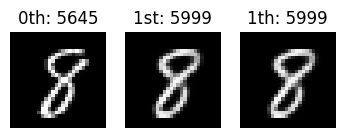

4, 5449.8369140625, 4958.951171875


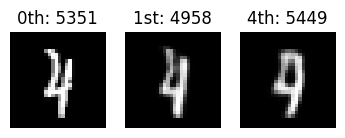

1, 5871.47265625, 5871.47265625


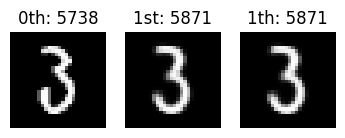

1, 5772.3349609375, 5772.3349609375


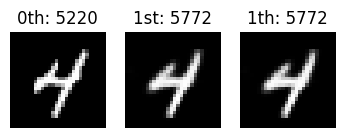

1, 8097.458984375, 8097.458984375


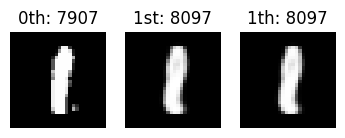

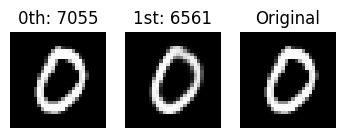

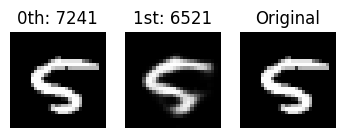

2, 5469.029296875, 4974.712890625


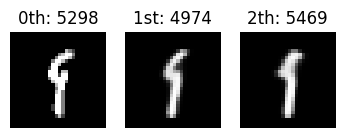

2, 8186.94921875, 7837.158203125


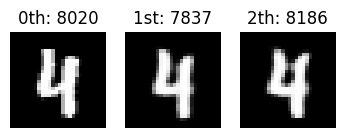

1, 8220.837890625, 8220.837890625


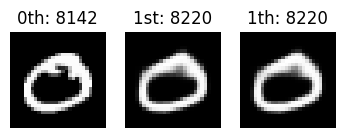

1, 4708.55126953125, 4708.55126953125


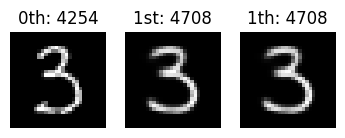

1, 7650.498046875, 7650.498046875


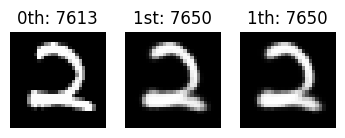

2, 4726.65234375, 4197.2333984375


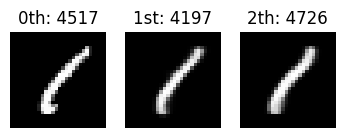

2, 9923.1708984375, 9718.3701171875


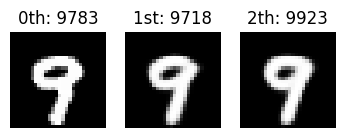

1, 9976.4482421875, 9976.4482421875


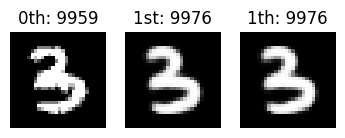

4, 6507.21630859375, 6301.21533203125


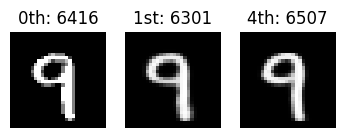

1, 10399.197265625, 10399.197265625


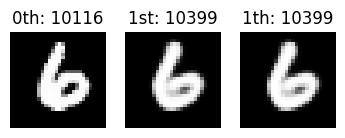

1, 7839.7919921875, 7839.7919921875


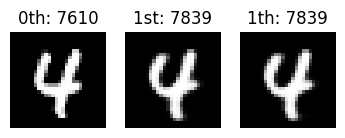

1, 4425.345703125, 4425.345703125


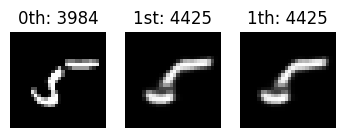

1, 9672.005859375, 9672.005859375


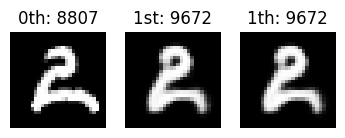

1, 8986.7060546875, 8986.7060546875


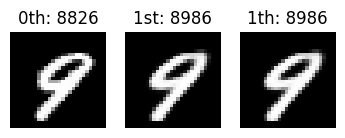

2, 5205.1103515625, 4787.94677734375


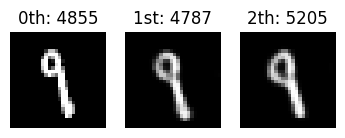

1, 7273.05029296875, 7273.05029296875


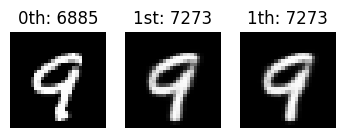

1, 4986.34619140625, 4986.34619140625


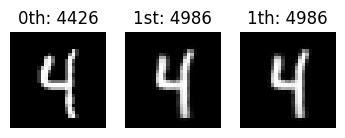

2, 11260.255859375, 10950.7216796875


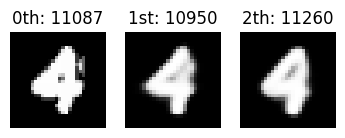

1, 5853.18310546875, 5853.18310546875


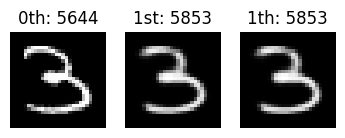

3, 10893.56640625, 10346.9404296875


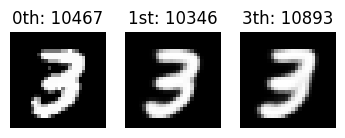

1, 4980.65478515625, 4980.65478515625


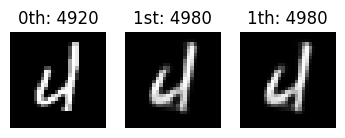

1, 9409.376953125, 9409.376953125


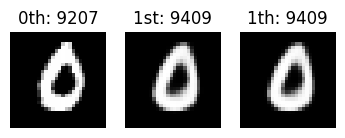

1, 8973.25390625, 8973.25390625


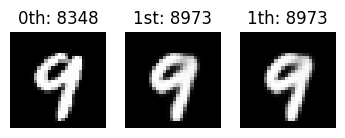

1, 5885.330078125, 5885.330078125


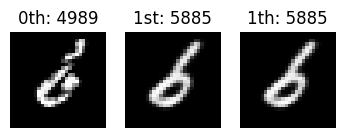

1, 7688.4228515625, 7688.4228515625


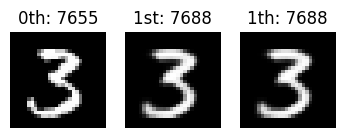

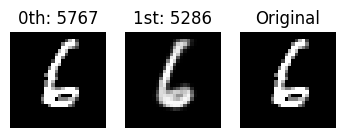

1, 4725.55908203125, 4725.55908203125


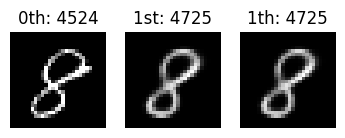

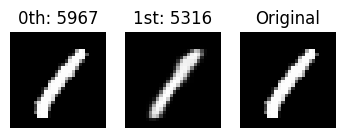

1, 9989.236328125, 9989.236328125


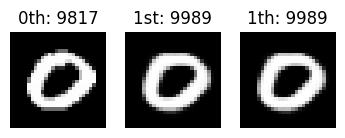

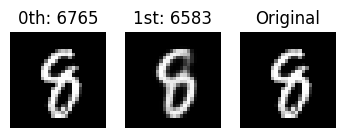

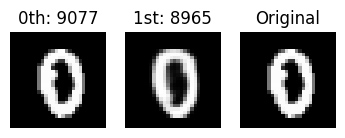

2, 5849.1455078125, 5417.810546875


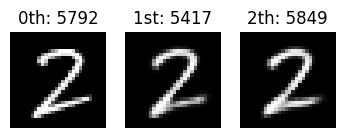

1, 3945.929443359375, 3945.929443359375


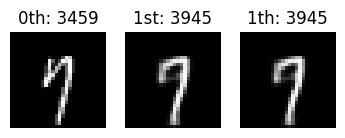

In [11]:
# Testing
data_loader = DataLoader(mnist_test, batch_size = 250, shuffle = True)
sampling = 5

for data, data_label in data_loader:
    fig, axes = plt.subplots(1, 3, figsize=(6*0.7, 2))
    image = data.to(device)
    values = evaluator(image.reshape(image.size(0),-1))[0]
    image_origin = image[0][0].cpu()
    value_origin = values.sum().item()
    axes[0].imshow(image_origin, cmap='gray')
    axes[0].set_title(f'0th: {int(value_origin)}')
    axes[0].axis('off')  # Turn off axis numbers

    recon_x = image
    count = 0
    for i in range(1, sampling):
        recon_x, mean, log_var = model(recon_x)
        image = recon_x[0].detach()
        values = evaluator(image.reshape(image.size(0),-1))[0]
        value_image = values.sum().item()

        if i == 1:
            value = value_image
            axes[1].imshow(image[0].cpu(), cmap='gray')
            axes[1].set_title(f'1st: {int(value_image)}')
            axes[1].axis('off')  # Turn off axis numbers

        if value_image >= value and value_image > value_origin:
            count += 1
            print(f"{i}, {value_image}, {value}")
            value = value_image
            axes[2].imshow(image[0].cpu(), cmap='gray')
            axes[2].set_title(f'{i}th: {int(value_image)}')
            axes[2].axis('off')  # Turn off axis numbers
            if count == 1:
                break
    if count == 0:
        axes[2].imshow(image_origin, cmap='gray')
        axes[2].set_title(f'Original')
        axes[2].axis('off')  # Turn off axis numbers
    plt.show()
    plt.close()